# INIT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# SK
# Kmeans & PCA
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA # No lo usamos ya
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules.get_data import get_data

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [ ]:
CLUSTER_COL = 'cluster'
FIGSIZE = (12, 8)
FIG_SQUARE = (10,10)

# Define la paleta de colores
my_colors = sns.color_palette("bright", n_colors=6)

# Establecer la paleta globalmente para seaborn
sns.set_palette(my_colors)

# Configurar matplotlib para usar la misma paleta
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=my_colors)

## Importacion datos

### CSVs

In [ ]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [ ]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [ ]:
# Seleccionar solo años 2014 a 2015 de df_s
df_s = df_s[(df_s['year'] >= 2014) & (df_s['year'] <= 2015)]

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

___
___

# SEGMENTACION

## Functions

In [ ]:
# CONSTANTES
FIGSIZE = (12, 6)
CLUSTER_COL = 'cluster'
SCALER = RobustScaler

In [ ]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [ ]:
# 1. Preparación de datos
def prepare_data(df):
    df['date'] = pd.to_datetime(df['date'])
    # Renombramos raw_earn a total_sales
    df.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return df

# 2. Crear features
def features_creation(df):
    product_data = df.groupby('item').agg({
        'sell_price': ['mean', 'median', 'std', 'min', 'max'],
        # 'units': ['sum', 'mean'],
        # 'total_sales': ['sum', 'mean']
    }).reset_index()

    product_data.columns = [
                            'item',
                            'avg_price',
                            'median_price',
                            'price_std',
                            'min_price',
                            'max_price',
                            ]

    product_data['price_range'] = product_data['max_price'] - product_data['min_price']
    product_data['price_volatility'] = product_data['price_std'] / product_data['avg_price']

    features = product_data.columns.tolist()
    features.remove('item')
    df_features = product_data[features]

    # return product_data, features
    return df_features, features, product_data

# # 3. Segmentación de productos usando K-means con RobustScaler
# 3.1 - Grafico silueta
def plot_silhouette(data_scaled, ran=20):

  silhouette_scores = []

  for k in range(2, ran):
      kmeans = init_kmeans(k)
      kmeans.fit(data_scaled)
      silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

  fig = px.line(
      x=range(2, 20),
      y=silhouette_scores,
      title="Silhouette score",
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

# 3.2 - Segementacion con optimal_k
def segment_products_kmeans(df, n_clusters=3):

    # FEATURE TOOLS -> helper
    X = data['df_features']
    features = data['features']
    product_data = data['product_data']
    X_scaled = data['X_scaled']
    scaler = data['scaler']
    # END FEATURE TOOLS

    # Aplica Kmeans sobre DF scalado -> helper
    kmeans = init_kmeans(n_clusters)
    product_data[CLUSTER_COL] = kmeans.fit_predict(X_scaled)

    # Calcula Silueta
    silhouette_avg = silhouette_score(X_scaled, product_data[CLUSTER_COL])
    print(f"El score de silueta promedio es: {silhouette_avg}")

    # Obtiene centroides y los devuelve en un DF
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=features)
    centroid_df[CLUSTER_COL] = range(n_clusters)
    print("\nCentroides de los clusters:")
    print(centroid_df)

    return product_data, centroid_df

# 4. Análisis de eventos integrado con segmentación
def analyze_segments(df, product_segments):
    # Unir df con product_segments en base a 'item'
    df = df.merge(product_segments[['item', 'cluster']], on='item', how='left')

    # Agrupar por cluster y calcular estadísticas agregadas
    cluster_analysis = df.groupby('cluster').agg({
        'total_sales': 'sum',
        'units': 'sum',
        'sell_price': 'mean'  # Precio promedio de venta
    }).reset_index()

    # Visualización de las ventas totales por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='total_sales', data=cluster_analysis, palette='viridis')
    ax.set_title('Ventas totales por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Ventas totales')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    # Visualización de las unidades vendidas por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='units', data=cluster_analysis, palette='viridis')
    ax.set_title('Unidades vendidas por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Unidades vendidas')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    # Visualización del precio de venta promedio por cluster
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster', y='sell_price', data=cluster_analysis, palette='viridis')
    ax.set_title('Precio de venta promedio por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Precio de venta promedio')
    # Añadir las cifras encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

    return cluster_analysis

# 5. Visualización de resultados
def visualize_results(product_segments, centroid_df):
    # Visualización de clusters según ventas totales y precio promedio
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=product_segments, x='total_sales', y='avg_price', hue=CLUSTER_COL, palette='viridis', s=100)
    sns.scatterplot(data=centroid_df, x='total_sales', y='avg_price', s=200, color='red', marker='X')
    plt.title('Segmentación de productos por ventas y precio promedio')
    plt.xlabel('Ventas totales')
    plt.ylabel('Precio de venta promedio')
    plt.legend(title='Cluster')
    plt.show()

In [ ]:
def scatter_plot_price_vs_units(data):
    # Agrupar por 'item' y calcular el precio máximo y la suma de unidades vendidas
    grouped_data = data.groupby('item').agg({
        'sell_price': 'max',  # Precio máximo por item
        'units': 'sum'       # Suma de unidades vendidas por item
    }).reset_index()

    # Renombramos columna sell_price a max_price
    grouped_data.rename(columns={'sell_price': 'max_price'}, inplace=True)

    # Calcular los cuartiles y la mediana del precio máximo
    q1 = grouped_data['max_price'].quantile(0.25)
    q3 = grouped_data['max_price'].quantile(0.75)
    median = grouped_data['max_price'].median()

    # Crear una nueva columna para la categoría de color
    conditions = [
        (grouped_data['max_price'] <= q1),  # Debajo de Q1
        (grouped_data['max_price'] > q1) & (grouped_data['max_price'] <= q3),  # Entre Q1 y Q3
        (grouped_data['max_price'] > q3)   # Por encima de Q3
    ]
    choices = ['Below Q1', 'Between Q1 and Q3', 'Above Q3']
    grouped_data['price_category'] = np.select(conditions, choices, default='Unknown')

    # Crear el scatter plot
    plt.figure(figsize=FIGSIZE)

    # Scatter plot con la escala de color basada en la categoría de precio
    scatter = sns.scatterplot(data=grouped_data, x='max_price', y='units', hue='price_category')

    # # Invertir el eje x para que vaya del precio máximo al mínimo
    # plt.gca().invert_xaxis()

    # Añadir líneas discontinuas para Q1, Q3 y la mediana
    plt.axvline(x=q1, color='gray', linestyle='--', label=f'Q1: {q1:.2f}', linewidth=0.3)
    plt.axvline(x=median, color='orange', linestyle='--', label=f'Mediana: {median:.2f}', linewidth=0.3)
    plt.axvline(x=q3, color='gray', linestyle='--', label=f'Q3: {q3:.2f}', linewidth=0.3)

    # Personalización del gráfico
    plt.title('Relación entre Precio Máximo y Unidades Vendidas por Producto')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Unidades Vendidas')

    # Mostrar la leyenda
    plt.legend(title='Categoría de Precio', loc='upper right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

def scatter_plot_price_vs_units_by_range(data):
    # limites
    low = 5
    high = 20

    # Agrupar por 'item' y calcular el precio máximo y la suma de unidades vendidas
    grouped_data = data.groupby('item').agg({
        'sell_price': 'max',  # Precio máximo por item
        'units': 'sum'        # Suma de unidades vendidas por item
    }).reset_index()

    # Renombramos columna sell_price a max_price
    grouped_data.rename(columns={'sell_price': 'max_price'}, inplace=True)

    # Crear una nueva columna para la categoría de rango de precios
    conditions = [
        (grouped_data['max_price'] <= low),  # Bajo ($0.12 - $10)
        (grouped_data['max_price'] > low) & (grouped_data['max_price'] <= high),  # Medio ($10 - $25)
        (grouped_data['max_price'] > high)   # Premium ($25 - $40)
    ]
    choices = ['Low Price', 'Mid Price', 'Premium Price']
    grouped_data['price_range'] = np.select(conditions, choices, default='Unknown')

    # Crear el scatter plot
    plt.figure(figsize=FIGSIZE)

    # Scatter plot con la escala de color basada en la categoría de rango de precios
    scatter = sns.scatterplot(data=grouped_data, x='max_price', y='units', hue='price_range')

    # Añadir líneas discontinuas para los límites de los rangos de precio
    plt.axvline(x=low, color='gray', linestyle='--', label=f'Límite Low Price: ${low}', linewidth=0.3)
    plt.axvline(x=high, color='gray', linestyle='--', label=f'Límite Mid Price: ${high}', linewidth=0.3)

    # Personalización del gráfico
    plt.title('Relación entre Precio Máximo y Unidades Vendidas por Producto')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Unidades Vendidas')

    # Mostrar la leyenda
    plt.legend(title='Rango de Precio', loc='upper right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_cluster_bars(data, target_col):
    # Filtrar solo las columnas numéricas
    numeric_cols = data.select_dtypes(include='number').columns.tolist()

    # Remover la columna del cluster de las columnas numéricas si está incluida
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    # Agrupar por la columna del cluster y calcular la media de las columnas numéricas
    cluster_means = data.groupby(target_col)[numeric_cols].mean()

    # Configurar el gráfico de barras
    cluster_means.plot(kind='bar', figsize=(10, 4))

    # Etiquetas y título
    plt.title('Comparación de Variables Numéricas por Cluster')
    plt.xlabel('Clusters')
    plt.ylabel('Media de las Variables')
    plt.xticks(rotation=0)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [ ]:
def scatter_plot_clusters(product_segments, centroid_df):
    # Crear el scatter plot
    plt.figure(figsize=(12, 6))

    # Scatter plot con el color basado en el cluster
    scatter = sns.scatterplot(data=product_segments, x='max_price', y='total_units', hue='cluster', palette='bright', alpha=0.8, s=100)

    # Añadir los centroides al gráfico
    plt.scatter(centroid_df['max_price'], [product_segments['total_units'].mean()] * len(centroid_df),
                color='red', s=100, marker='X', label='Centroides', linewidth=0.3)

    # Personalización del gráfico
    plt.title('Scatter Plot de Productos por Cluster con Centroides')
    plt.xlabel('Precio Máximo')
    plt.ylabel('Total de Unidades Vendidas')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico

    # Ajustar el layout
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [ ]:
# Analizamos en profundidad los precios de los productos
def detailed_sales_below_max(data):
    # Agrupar por 'item' y calcular el precio máximo, mínimo, y total de unidades vendidas
    summary = data.groupby('item').agg(
        max_price=('sell_price', 'max'),                          # Precio máximo por producto
        min_price=('sell_price', 'min'),                          # Precio mínimo por producto
        total_units=('units', 'sum'),                             # Total de unidades vendidas
        sales_below_max=('sell_price', lambda x: (x < x.max()).sum()),  # Conteo de ventas por debajo del máximo
        units_below_max=('units', lambda x: x[data['sell_price'] < data['sell_price'].max()].sum()),  # Unidades vendidas por debajo del máximo
        sales_at_max=('sell_price', lambda x: (x == x.max()).sum()),  # Conteo de ventas a precio máximo
        most_frequent_price=('sell_price', lambda x: x.mode()[0])  # Precio más frecuente de venta
    ).reset_index()

    # Calcular la mayor diferencia entre el precio máximo y el mínimo
    summary['max_min_diff'] = summary['max_price'] - summary['min_price']

    # Calcular el porcentaje de ventas por debajo del máximo
    summary['percentage_below_max'] = (summary['sales_below_max'] / summary['total_units']) * 100

    # Renombrar las columnas para mayor claridad
    summary.rename(columns={'sales_below_max': 'times_below_max'}, inplace=True)

    # Reordenar columnas: Primero las de precio y luego las de unidades
    ordered_columns = [
        'item',
        'max_price',          # Precio máximo por producto.
        'min_price',          # Precio mínimo por producto
        'max_min_diff',       # Diferencia máxima entre el precio máximo y el mínimo (mayor oferta)
        'total_units',        # Total de unidades vendidas
        'units_below_max',    # Total de unidades vendidas cuando el precio no era su máximo (en oferta)
        'times_below_max',    # Número de veces que se vendió por debajo del máximo
        'sales_at_max',       # Número de veces que se vendió al precio máximo
        'most_frequent_price', # Precio al que más veces se ha vendido
        'percentage_below_max'  # Porcentaje de ventas por debajo del máximo
    ]

    summary = summary[ordered_columns]

    # Mostrar el resultado
    return summary

In [ ]:
def plot_horizontal_bars(data):
    # Establecer el tamaño de la figura
    plt.figure(figsize=FIGSIZE)

    # Crear el gráfico de barras horizontal
    sns.barplot(data=data, x='max_price', y='item', palette='viridis', orient='h')

    # Añadir anotaciones con los valores redondeados a 2 decimales, el símbolo de dólar y el tamaño de letra
    for i, (sales, freq_price, below_max) in enumerate(zip(data['sales_at_max'], data['most_frequent_price'], data['units_below_max'])):
        plt.text(x=data['max_price'].iloc[i] + 1,
                 y=i,
                 s=f'Sales@Max: {sales}\nFreq.Price: ${freq_price:.2f}\nUnits<BMax: {below_max}\n',
                 va='center', ha='left', color='black', fontsize=8)  # Cambia fontsize para ajustar el tamaño de letra

    # Añadir grid de líneas verticales para los precios
    plt.grid(axis='x', linestyle='--', color='grey', alpha=0.7)  # Configura el grid en el eje x (vertical)

    # Personalización del gráfico
    plt.title('Max Price por Producto con Información Adicional')
    plt.xlabel('Precio Máximo ($)')
    plt.ylabel('Producto (Item)')

    # Ajustar layout para evitar solapamientos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

## Data (copy)

In [ ]:
items = df_items.copy()
shops = df_shops.copy()
df_pr = df_s.copy()

display(df_pr.shape)

(8217627, 12)

In [ ]:
# Añadimos category a df_pr desde items
df_pr = df_pr.merge(items[['item', 'category']], on='item', how='left')

## MAX PRICE = BASE PRICE

Entendemos que el precio max de cada producto es el precio real y cualquier precio que haya por debajo es producto de ofertas, promociones, etc... Usamos el precio max como ancla para poder encontrar las clasificaciones en las que se mueven nuestros productos.

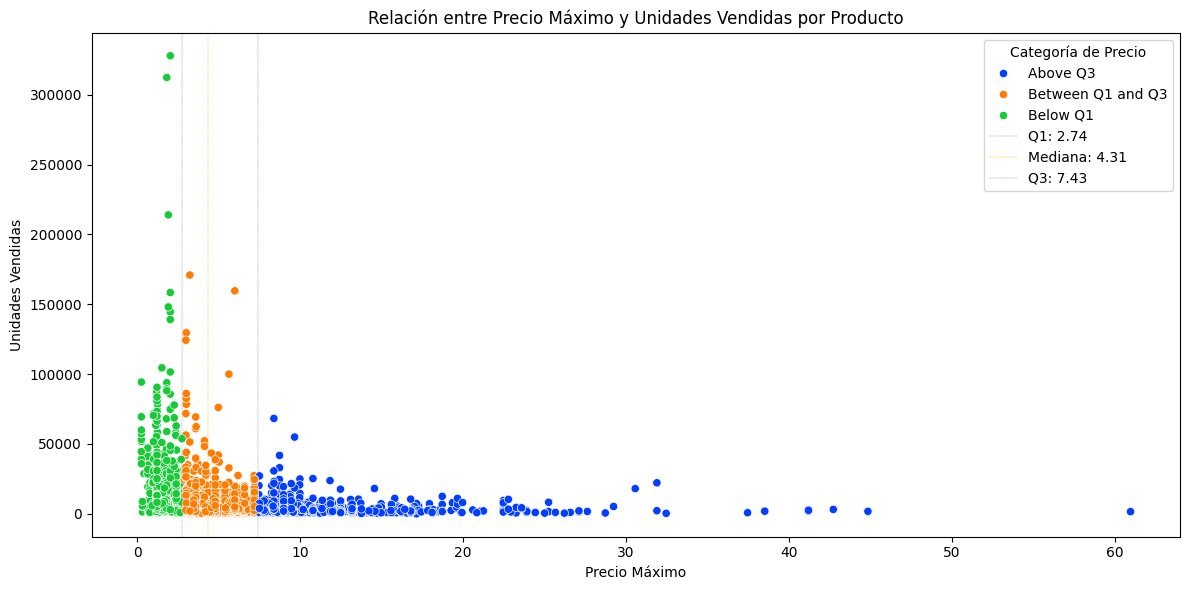

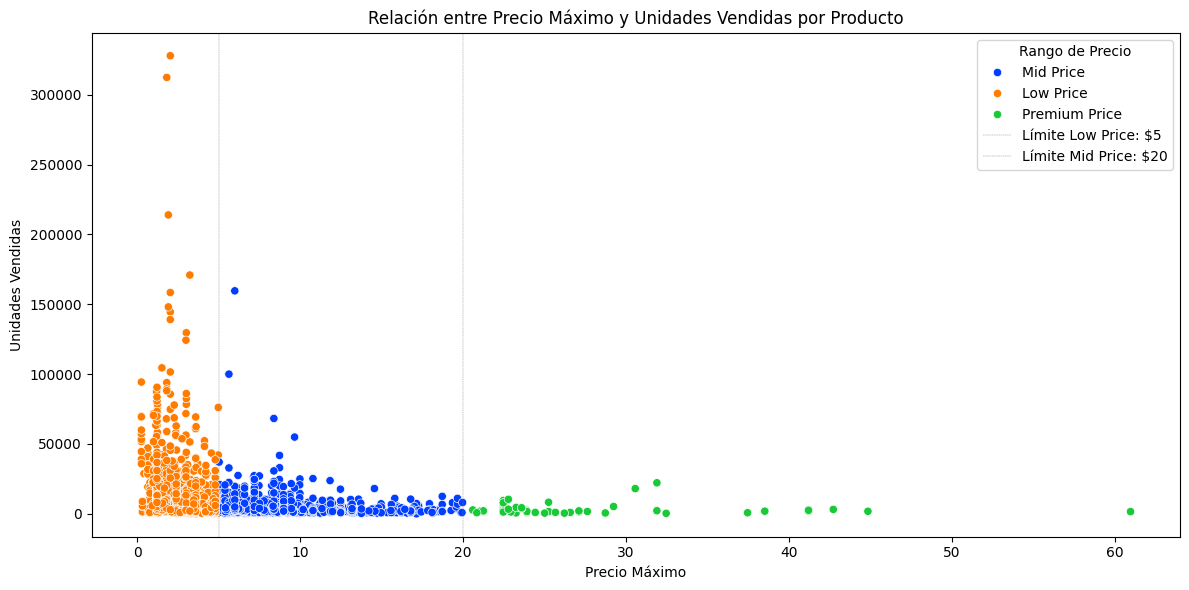

In [ ]:
# Division segun cuartiles
scatter_plot_price_vs_units(df_pr)

# Division segun rangos predefinidos
scatter_plot_price_vs_units_by_range(df_pr)

In [ ]:
# Vemos detalles de ventas
detailed_count = detailed_sales_below_max(df_pr)

dt = detailed_count['max_price'].describe()

display(dt.to_frame().transpose())

,count,mean,std,min,25%,50%,75%,max
max_price,3048.0,5.766844,4.844663,0.24,2.736,4.3092,7.425,60.975


In [ ]:
# Vemos orden de datos diferentes para hacernos una idea de que sucede con los precios
detailed_count = detailed_count.sort_values(by='total_units', ascending=False)

display(detailed_count.head())

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
2809,SUPERMARKET_3_586,2.016,1.896,0.120,327839,327839,2047,5227,2.016,0.624392
2313,SUPERMARKET_3_090,1.800,1.200,0.600,312326,312326,5185,358,1.776,1.660124
2475,SUPERMARKET_3_252,1.896,1.776,0.120,213922,213922,1068,6169,1.896,0.499247
2810,SUPERMARKET_3_587,3.216,2.244,0.972,170911,170911,6554,21,2.976,3.834744
2343,SUPERMARKET_3_120,5.976,5.976,0.000,159598,159598,0,6177,5.976,0.000000


In [ ]:
# Ranking productos mas caros
detailed_count = detailed_count.sort_values(by='max_price', ascending=False)

display(detailed_count.head(10))

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
1560,HOME_&_GARDEN_2_466,60.9750,7.4625,53.5125,1591,1590,1237,1,8.7125,77.749843
1500,HOME_&_GARDEN_2_406,44.8500,12.4750,32.3750,1827,1827,1442,3,15.5750,78.927203
1344,HOME_&_GARDEN_2_250,42.7250,8.7000,34.0250,3172,3172,2273,3,8.7000,71.658260
58,ACCESORIES_1_060,41.2034,35.8834,5.3200,1922,1922,1081,506,35.8834,56.243496
352,ACCESORIES_1_361,41.2034,35.8834,5.3200,2516,2516,1292,761,41.2034,51.351351
217,ACCESORIES_1_225,41.2034,35.8834,5.3200,2894,2894,1495,791,41.2034,51.658604
384,ACCESORIES_1_393,38.5168,37.2001,1.3167,1796,1796,446,1071,38.5168,24.832962
401,ACCESORIES_1_410,38.5168,37.2001,1.3167,1917,1917,447,1150,38.5168,23.317684
622,HOME_&_GARDEN_1_060,37.4625,37.4625,0.0000,793,793,0,709,37.4625,0.000000
1540,HOME_&_GARDEN_2_446,32.4625,18.7375,13.7250,379,379,1,350,32.4625,0.263852


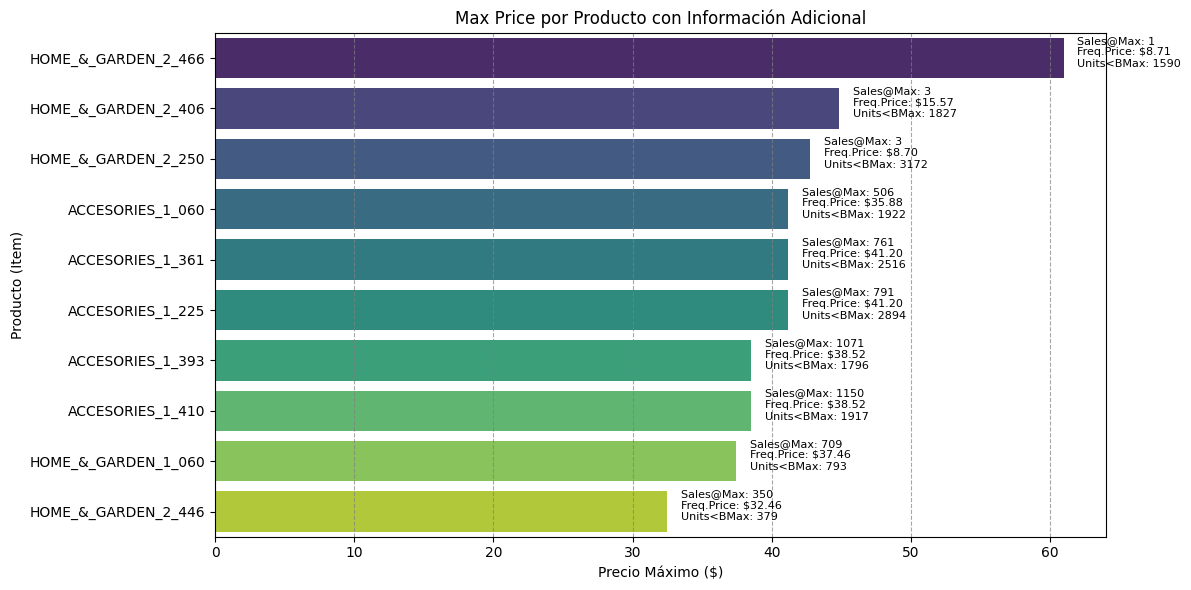

In [ ]:
cs = ['item', 'max_price', 'min_price', 'units_below_max', 'sales_at_max', 'most_frequent_price']

plot_data = detailed_count[cs].head(10)

plot_horizontal_bars(plot_data)

In [ ]:
# Vemos ranking de productos segun precio mas frecuente
display(detailed_count.sort_values(by='most_frequent_price', ascending=False).head(5))

# Ranking productos que mayor descuento han sufrido
display(detailed_count.sort_values(by='max_min_diff', ascending=False).head(5))

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
217,ACCESORIES_1_225,41.2034,35.8834,5.3200,2894,2894,1495,791,41.2034,51.658604
352,ACCESORIES_1_361,41.2034,35.8834,5.3200,2516,2516,1292,761,41.2034,51.351351
401,ACCESORIES_1_410,38.5168,37.2001,1.3167,1917,1917,447,1150,38.5168,23.317684
384,ACCESORIES_1_393,38.5168,37.2001,1.3167,1796,1796,446,1071,38.5168,24.832962
622,HOME_&_GARDEN_1_060,37.4625,37.4625,0.0000,793,793,0,709,37.4625,0.000000


,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max
1560,HOME_&_GARDEN_2_466,60.9750,7.4625,53.5125,1591,1590,1237,1,8.7125,77.749843
1344,HOME_&_GARDEN_2_250,42.7250,8.7000,34.0250,3172,3172,2273,3,8.7000,71.658260
1500,HOME_&_GARDEN_2_406,44.8500,12.4750,32.3750,1827,1827,1442,3,15.5750,78.927203
1608,HOME_&_GARDEN_2_514,24.4250,1.2500,23.1750,951,951,409,430,24.4250,43.007361
900,HOME_&_GARDEN_1_342,22.4625,1.2500,21.2125,7197,7197,1177,2664,22.4625,16.354036


**Análisis**:  
Para no perder la información del precio real de venta utilizaremos el precio máximo (o base) y el precio de venta más frecuente para realizar el clustering.

In [ ]:
# Preprocesamiento
features = detailed_count.columns.tolist()
features = ['item','max_price', 'most_frequent_price'] # Para no perder la info del precio 'real' con el que se suelen vender
features.remove('item')

df_to_scale = detailed_count[features]
scl = RobustScaler # para evitar outliers etc...
scaled_df, scaler = preprocess_features(df_to_scale, Scaler=scl)

In [ ]:
# Silhouette
plot_silhouette(scaled_df, ran=20)

In [ ]:
# Segmentacion con optimal_k
optimal_k = 3 # => Silueta dice 2, aunque solo hay poca diferencia con 3 => intentamos identificar low - med - premium

data = {
    'df_features': detailed_count[features],
    'features': features,
    'product_data': detailed_count,
    'X_scaled': scaled_df,
    'scaler': scaler
}

product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

El score de silueta promedio es: 0.6171040220539098

Centroides de los clusters:
   max_price  most_frequent_price  cluster
0  20.331767            19.365499        0
1   3.170496             3.106166        1
2   8.611674             8.386463        2


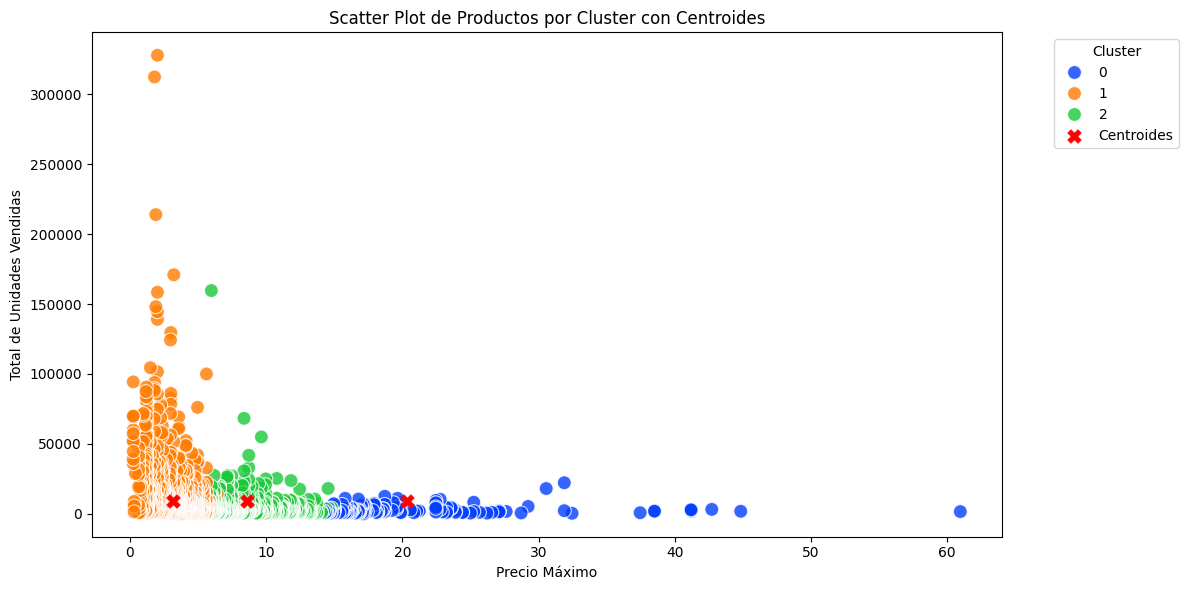

In [ ]:
# Visualizacion
scatter_plot_clusters(product_segments, centroid_df)

In [ ]:
display(product_segments.head())

display(centroid_df.head())

,item,max_price,min_price,max_min_diff,total_units,units_below_max,times_below_max,sales_at_max,most_frequent_price,percentage_below_max,cluster
1560,HOME_&_GARDEN_2_466,60.9750,7.4625,53.5125,1591,1590,1237,1,8.7125,77.749843,0
1500,HOME_&_GARDEN_2_406,44.8500,12.4750,32.3750,1827,1827,1442,3,15.5750,78.927203,0
1344,HOME_&_GARDEN_2_250,42.7250,8.7000,34.0250,3172,3172,2273,3,8.7000,71.658260,0
58,ACCESORIES_1_060,41.2034,35.8834,5.3200,1922,1922,1081,506,35.8834,56.243496,0
352,ACCESORIES_1_361,41.2034,35.8834,5.3200,2516,2516,1292,761,41.2034,51.351351,0


,max_price,most_frequent_price,cluster
0,20.331767,19.365499,0
1,3.170496,3.106166,1
2,8.611674,8.386463,2


## Diccionario de cluster con descripciones

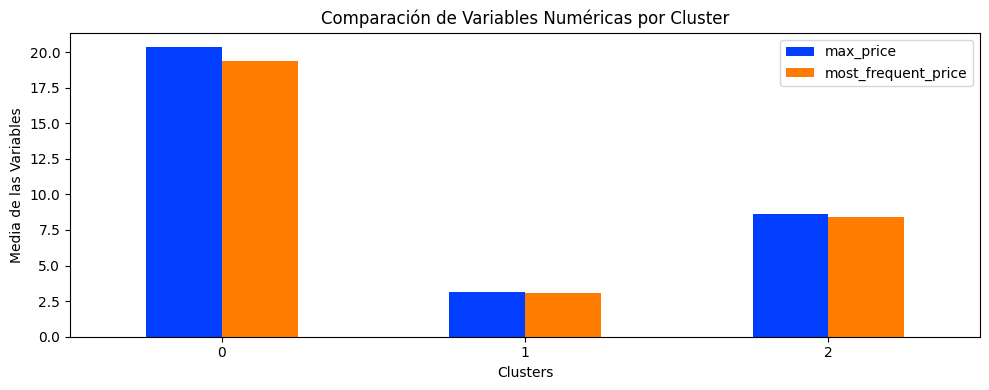

In [ ]:
plot_cluster_bars(centroid_df, target_col='cluster')

In [ ]:
# Mostramos el precio maximo de cada cluster
display(product_segments.groupby('cluster')['max_price'].max().to_frame().transpose())

cluster,0,1,2
max_price,60.975,6.6101,16.416


In [ ]:
#  Vemos items por cluster
def plot_clusters_sizes(data_labeled):
    cluster_counts = data_labeled[CLUSTER_COL].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(range(len(cluster_counts))))

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel(CLUSTER_COL)
    ax.set_ylabel('Número de items')
    ax.set_title('Número de items por cluster')
    ax.set_xticks(range(len(cluster_counts)))
    ax.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_counts))], rotation=0)
    plt.show()

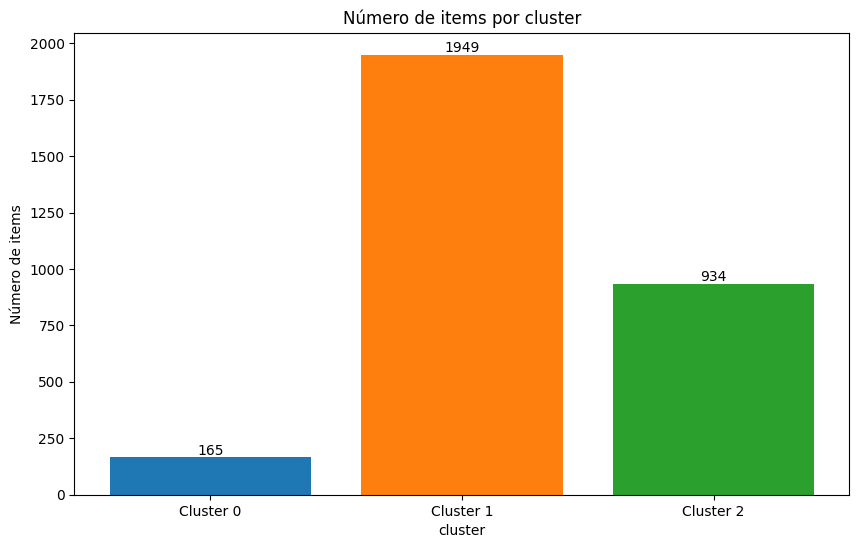

In [ ]:
plot_clusters_sizes(product_segments)

In [ ]:
cl_desc = {
    0: 'Premium',
    1: 'Low',
    2: 'Mid'
}

product_segments[CLUSTER_COL] = product_segments[CLUSTER_COL].map(cl_desc)

# Renombramos columna CLUSTER_COL a 'price_range'
product_segments.rename(columns={CLUSTER_COL: 'price_range'}, inplace=True)

# Añadimos columna 'price_range' a df_items usando columna 'item' desde product_segments
df_items['price_range'] = df_items['item'].map(product_segments.set_index('item')['price_range'])

In [ ]:
display(df_items.head())

,item,category,department,price_range
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Mid
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Low
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Low
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Mid
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Low


# Comprobacion conclusiones

In [ ]:
# Elejimos 3 items al azar de df_items y los guardamos en test_items
test_items = []
test_items = df_items.sample(n=3, random_state=42)

display(test_items)
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
# Calculamos precio maximo en df_s y vemos si se corresponde
for test in test_items['item'].unique():
  print(test)
  # Seleccionamos item de df_s
  df_s_item = df_s[df_s['item'] == test]
  # Calculamos max_price
  max_price = df_s_item['sell_price'].max()
  print(f'Max_Price: {max_price}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

,item,category,department,price_range
1517,HOME_&_GARDEN_2_422,HOME_&_GARDEN,HOME_&_GARDEN_2,Mid
2369,SUPERMARKET_3_145,SUPERMARKET,SUPERMARKET_3,Low
1961,SUPERMARKET_2_135,SUPERMARKET,SUPERMARKET_2,Low


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
HOME_&_GARDEN_2_422
Max_Price: 6.2125
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
SUPERMARKET_3_145
Max_Price: 3.576
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
SUPERMARKET_2_135
Max_Price: 2.976
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


# Informes adicionales

In [ ]:
def clusters_boxplots(data_labeled, target_col):
  display(data_labeled.shape)

  # Assuming data_labeled contains your data
  num_features = len(data_labeled.columns[1:-1])  # Exclude 'item' and 'cluster'
  display(num_features)

  # Calculate number of rows and cols dynamically
  num_cols = 3  # You can adjust this to change the grid layout
  num_rows = (num_features + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))

  # Flatten axes array to iterate through it
  axes = axes.flatten()

  # Plot boxplots for each feature
  for i, feature in enumerate(data_labeled.columns[1:-1]):
    sns.boxplot(x=target_col, y=feature, data=data_labeled, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} across Clusters')

  # Hide empty subplots if any (when num_features is not divisible by num_cols)
  for i in range(num_features, num_rows * num_cols):
    if i < len(axes):  # Check if the extra subplot exists
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

(3048, 11)

9

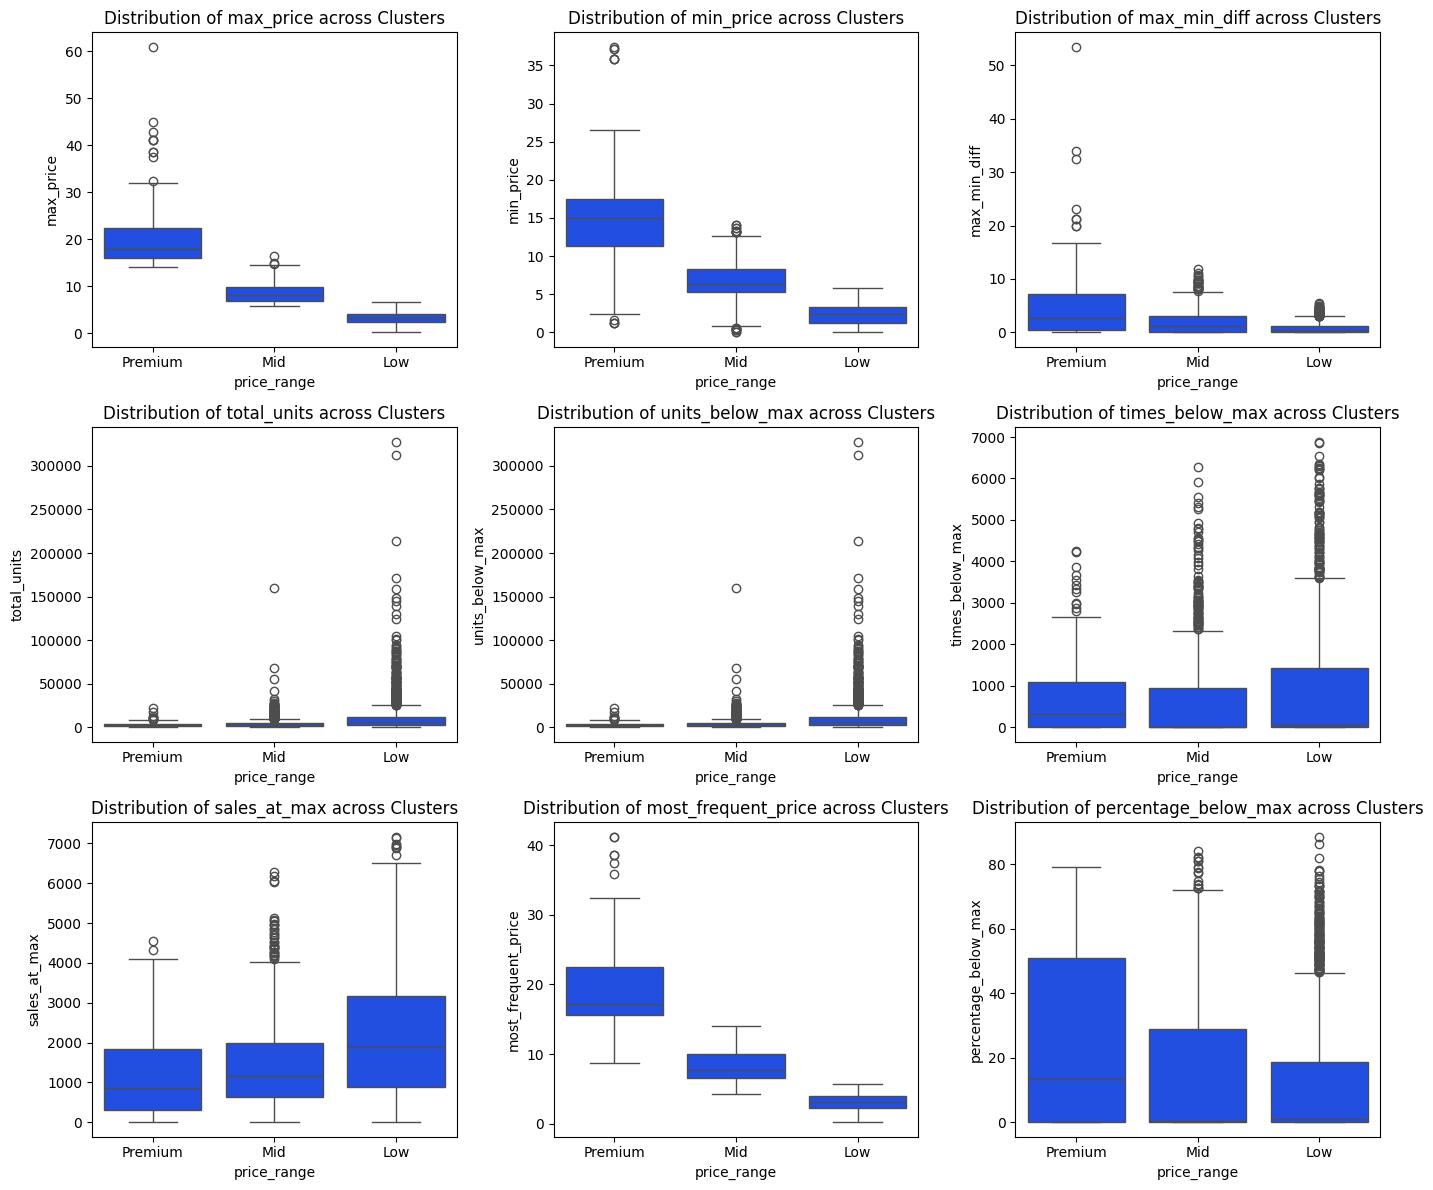

In [ ]:
# Distribucion precios segun segmentos
clusters_boxplots(product_segments, target_col='price_range')

In [ ]:
# Comparación del rendimiento entre clusters según categorías de productos
def compare_performance_by_price_range(data):
    # Agrupamos por 'category' y 'price_range', sumando las unidades vendidas ('units') y las ganancias brutas ('raw_earn')
    grouped = data.groupby(['category', 'price_range'])[['units', 'raw_earn']].sum().reset_index()

    # Normalizamos las unidades vendidas y el ingreso bruto dentro de cada categoría (comparación relativa)
    grouped['units_percentage'] = grouped.groupby('category')['units'].transform(lambda x: (x / x.sum()) * 100)
    grouped['raw_earn_percentage'] = grouped.groupby('category')['raw_earn'].transform(lambda x: (x / x.sum()) * 100)

    # Gráfico de comparación de rendimiento por categorías
    plt.figure(figsize=FIGSIZE)

    # Graficamos las unidades vendidas
    sns.barplot(data=grouped, x='category', y='units_percentage', hue='price_range', palette='bright')
    plt.title('Comparación de Unidades Vendidas por Categoría y Rango de Precio')
    plt.ylabel('Porcentaje de Unidades Vendidas (%)')
    plt.xlabel('Categoría de Producto')
    plt.legend(title='Rango de Precio')
    plt.tight_layout()
    # Añadir los porcentajes en la parte superior de cada barra
    for ax in plt.gcf().axes:  # Recorrer todos los ejes (gráficos) de la figura actual
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x = p.get_x()
            y = p.get_y()

            # Calcular el porcentaje sobre el total
            percentage = (height / grouped['units_percentage'].sum()) * 100 if ax.get_ylabel() == 'Porcentaje de Unidades Vendidas (%)' else (height / grouped['raw_earn_percentage'].sum()) * 100

            # Mostrar el porcentaje solo si es mayor que 0
            if height > 0:
                ax.annotate(f'{percentage:.2f}%', (x + width / 2, height), ha='center', va='bottom', fontsize=10)
    plt.show()

    # Graficamos las ganancias brutas
    plt.figure(figsize=FIGSIZE)
    sns.barplot(data=grouped, x='category', y='raw_earn_percentage', hue='price_range', palette='bright')
    plt.title('Comparación de Ganancias Brutas por Categoría y Rango de Precio')
    plt.ylabel('Porcentaje de Ganancias Brutas (%)')
    plt.xlabel('Categoría de Producto')
    plt.legend(title='Rango de Precio')
    plt.tight_layout()
    # Añadir los porcentajes en la parte superior de cada barra
    for ax in plt.gcf().axes:  # Recorrer todos los ejes (gráficos) de la figura actual
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x = p.get_x()
            y = p.get_y()

            # Calcular el porcentaje sobre el total
            percentage = (height / grouped['units_percentage'].sum()) * 100 if ax.get_ylabel() == 'Porcentaje de Unidades Vendidas (%)' else (height / grouped['raw_earn_percentage'].sum()) * 100

            # Mostrar el porcentaje solo si es mayor que 0
            if height > 0:
                ax.annotate(f'{percentage:.2f}%', (x + width / 2, height), ha='center', va='bottom', fontsize=10)
    plt.show()

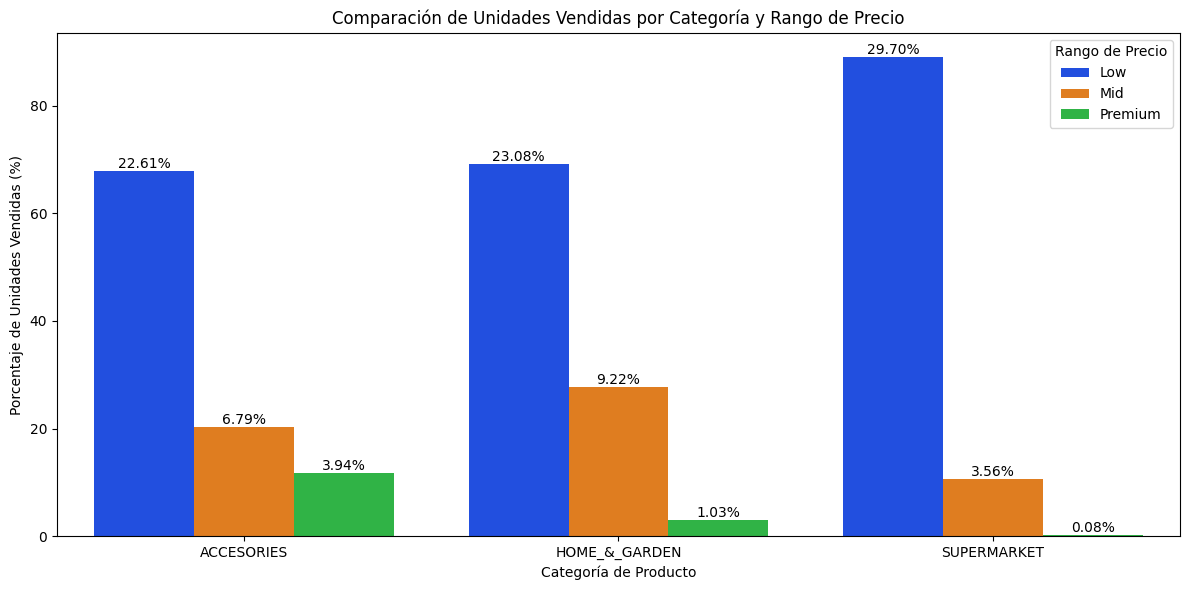

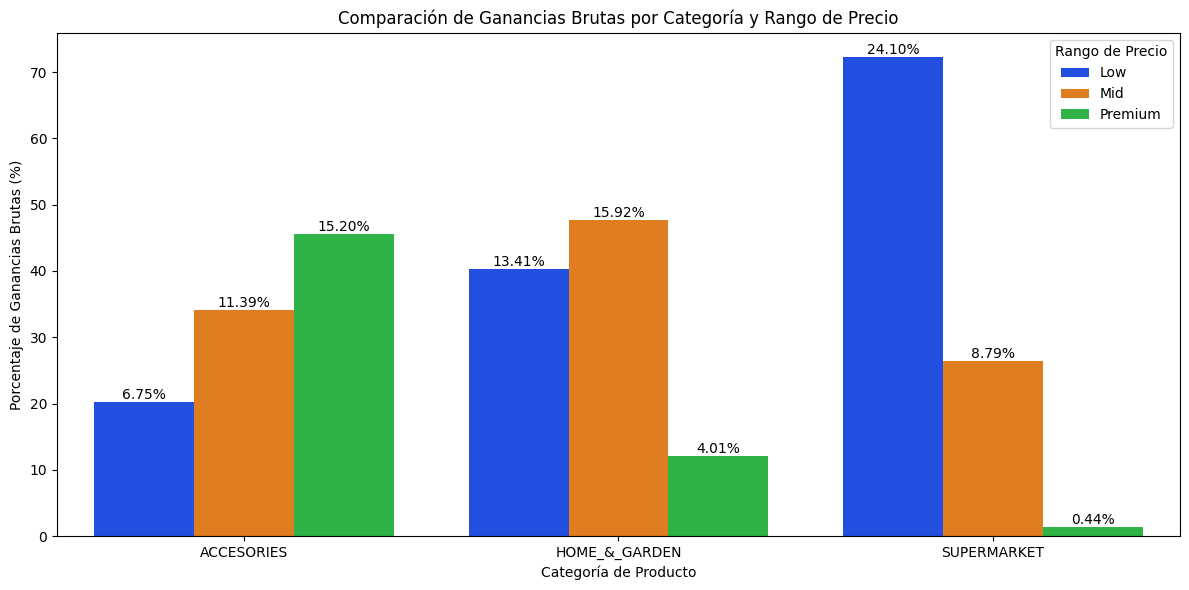

In [ ]:
compare_performance_by_price_range(df_pr)

# Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_with_price_range.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# df_items.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>